<a href="https://colab.research.google.com/github/sbooeshaghi/colosseum/blob/master/analysis/figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Fri Dec 18 22:51:26 UTC 2020


In [2]:
!git clone https://github.com/sbooeshaghi/colosseum.git

Cloning into 'colosseum'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 330 (delta 58), reused 70 (delta 25), pack-reused 212
Receiving objects: 100% (330/330), 4.58 MiB | 22.76 MiB/s, done.
Resolving deltas: 100% (159/159), done.


# Experiment 1 Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.patches as mpatches
import math
from matplotlib.ticker import MaxNLocator


plt.rcParams.update({'font.size': 20})
%config InlineBackend.figure_format = 'retina'

In [4]:
tare = [1234.3, 1230.3, 1251.4, 1238.2, 1235.7]
empty = np.mean(tare)
print(empty)

1237.98


In [5]:
df = pd.read_csv("/content/colosseum/data/experiment_1.txt", sep="\t")

In [6]:
df.head()

,Trial,Experiment [mL/s],Total weight [mg],Fluid weight [mg]
0,1,0.2,2242.7,1004.72
1,2,0.2,2272.1,1034.12
2,3,0.2,2241.8,1003.82
3,4,0.2,2234.9,996.92
4,5,0.2,2267.2,1029.22


In [7]:
conditions = np.unique(df["Experiment [mL/s]"].values)

In [8]:
data = []
stdev = []
for condish in conditions:
    d = df[df["Experiment [mL/s]"]==condish]["Fluid weight [mg]"].values
    
    s = df[df["Experiment [mL/s]"]==condish]["Fluid weight [mg]"].values.std()
    
    m = d.mean()
    data.append(d)
    
    stdev.append(s/m)

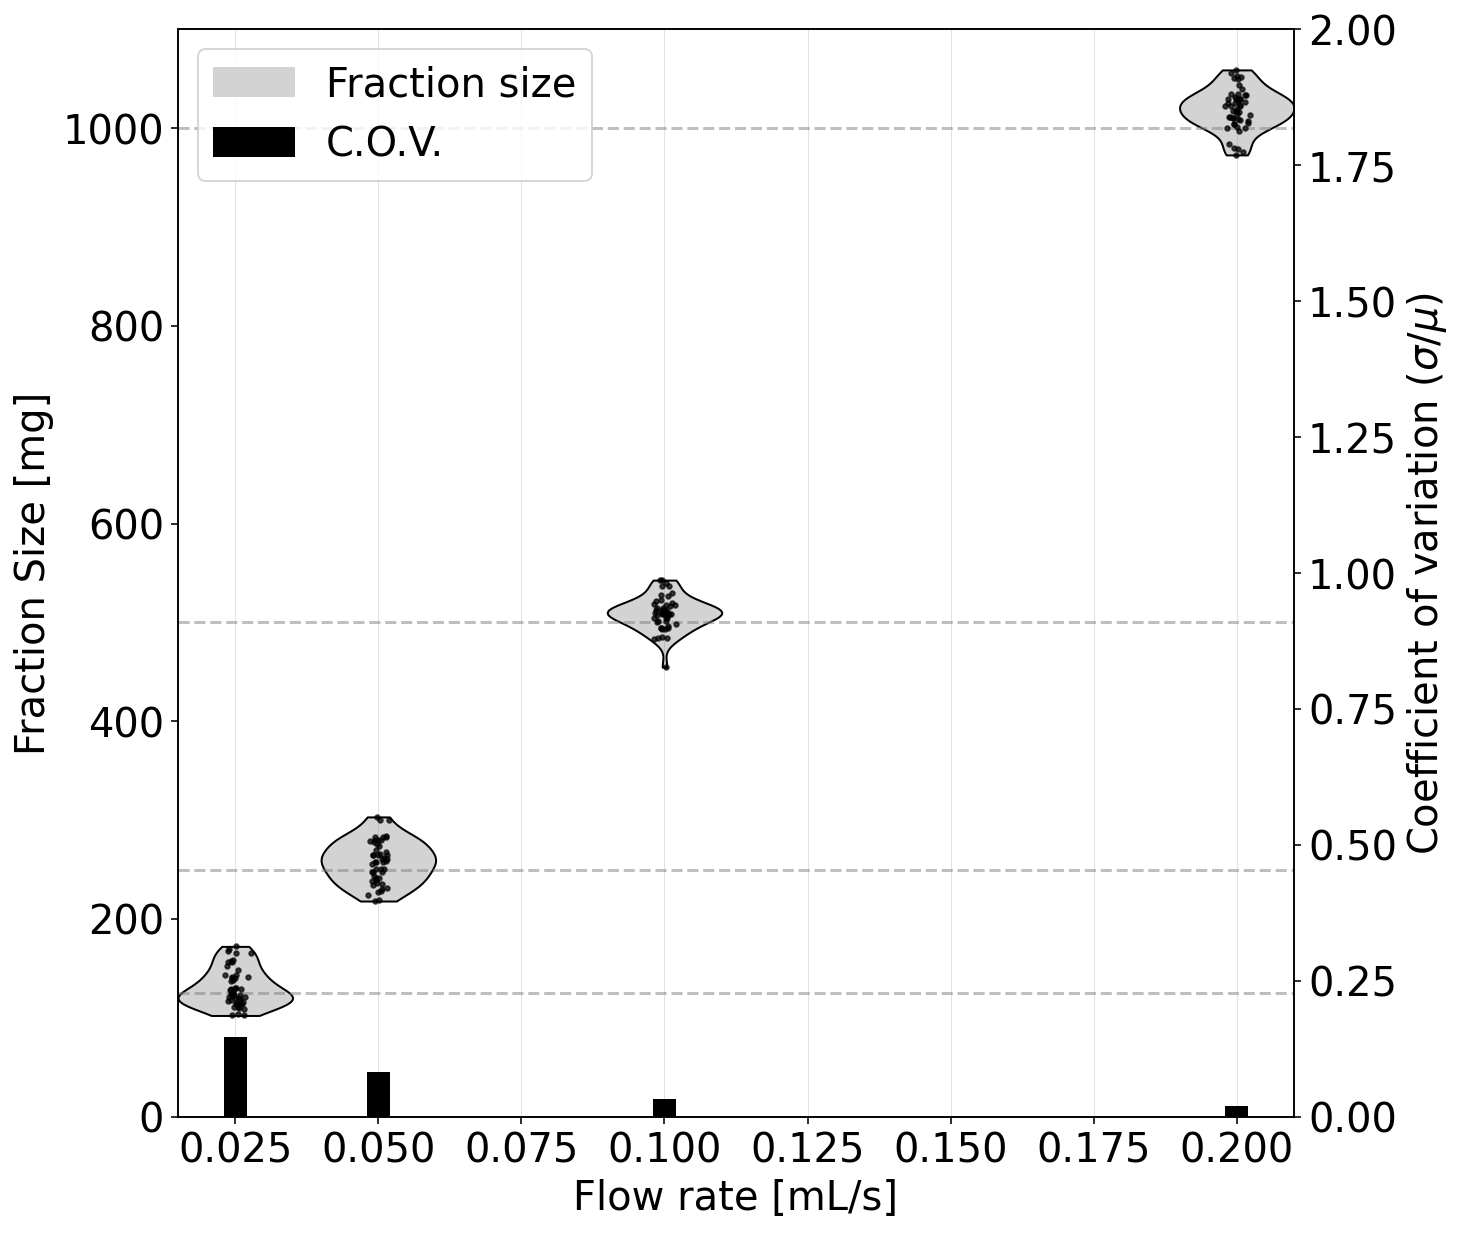

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

ax2=ax.twinx()
parts = ax.violinplot(data, conditions, widths=0.02,
                      showmeans=False, showextrema=False, showmedians=False,
                      bw_method='silverman')

for pc in parts['bodies']:
    pc.set_facecolor('lightgrey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    
ax.set_xlabel("Flow rate [mL/s]")
ax.set_ylabel("Fraction Size [mg]")
ax.set_ylim(0, 1100)
ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", axis="x", alpha = 0.2)

ax.axhline(y=125, color ='grey', alpha=0.5, linestyle="--")
ax.axhline(y=250, color ='grey', alpha=0.5, linestyle="--")
ax.axhline(y=500, color ='grey', alpha=0.5, linestyle="--")
ax.axhline(y=1000, color='grey', alpha=0.5, linestyle="--")
ax.set_xlim(0.015, 0.21)


ax2.set_ylim(0, 2)
ax2.set_ylabel("Coefficient of variation ($\sigma/\mu$)")
ax2.bar(conditions, stdev, width=0.004, color="black")


for idx, condish in enumerate(conditions):
    x = np.random.normal(condish, 0.001, size=len(data[idx]))
    ax.scatter(x, data[idx], color="black", zorder=15, s=5, alpha=0.7)
    
    
grey_patch = mpatches.Patch(color='lightgrey', label='Fraction size')
black_patch = mpatches.Patch(color='black', label='C.O.V.')
plt.legend(handles=[grey_patch, black_patch], loc="upper left")
# plt.savefig("../figures/fraction_flowrate.pdf", bbox_inches='tight')
# plt.savefig("../figures/fraction_flowrate.png", bbox_inches='tight', dpi=100)
fig.show()

# Experiment 2 Analysis

In [10]:
df2 = pd.read_csv("/content/colosseum/data/experiment_2.txt", sep="\t")

In [11]:
df2.head()

,Collection Time (s),Experiment,Total weight [mg],Fluid weight [mg]
0,2,1,1348.2,110.22
1,4,1,1477.7,239.72
2,6,1,1561.2,323.22
3,8,1,1619.7,381.72
4,10,1,1785.7,547.72


In [12]:
experiments = np.unique(df2["Experiment"].values)
tpts = np.arange(2, 32, 2)
means = df2.groupby(["Collection Time (s)"])["Fluid weight [mg]"].mean()

In [13]:
slope, intercept, r_value, p_value, std_err = stats.linregress(tpts, means)

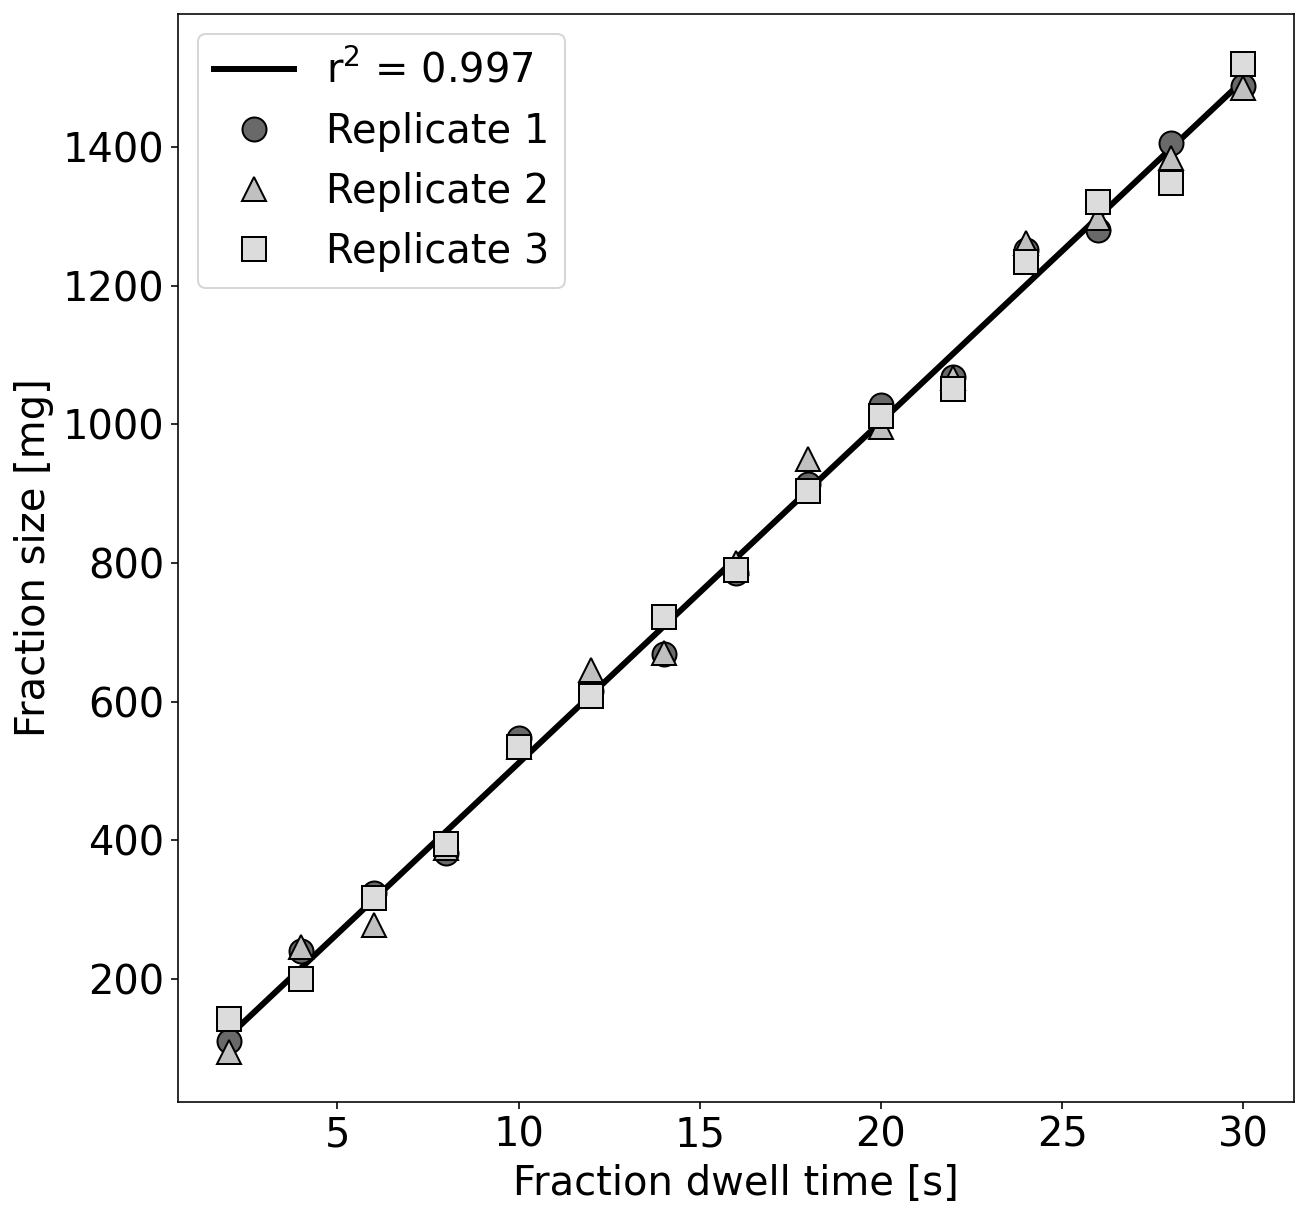

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(tpts, intercept + slope*tpts, 'black', label='r$^2$ = {:.3f}'.format(r_value**2), linewidth=3)


shapes = ["o", "^", "s"]
colors = ["dimgrey", "silver", "gainsboro"]

for idx, exp in enumerate(experiments):
    tmp = df2[df2["Experiment"] == exp]
    cumsum = tmp["Fluid weight [mg]"].values.cumsum()
    
    ax.plot(tmp["Collection Time (s)"].values, tmp["Fluid weight [mg]"].values, label="Replicate {}".format(idx+1),linestyle='None', marker=shapes[idx], color=colors[idx], markeredgecolor='black', markersize=12)
    
ax.set_xlabel("Fraction dwell time [s]")
ax.set_ylabel("Fraction size [mg]")


plt.legend()

# plt.savefig("../figures/fraction_dwelltime.pdf", bbox_inches='tight')
# plt.savefig("../figures/fraction_dwelltime.png", bbox_inches='tight', dpi=100)


plt.show()

# Plot Archimedian spiral

In [15]:
def spiral_points(arc=1, separation=1):
    """generate points on an Archimedes' spiral
    with `arc` giving the length of arc between two points
    and `separation` giving the distance between consecutive 
    turnings
    - approximate arc length with circle arc at given distance
    - use a spiral equation r = b * phi
    """
    def p2c(r, phi):
        """polar to cartesian
        """
        return (r * math.cos(phi), r * math.sin(phi))

    # yield a point at origin
    yield (0, 0)

    # initialize the next point in the required distance
    r = arc
    b = separation / (2 * math.pi)
    # find the first phi to satisfy distance of `arc` to the second point
    phi = float(r) / b
    while True:
        yield p2c(r, phi)
        # advance the variables
        # calculate phi that will give desired arc length at current radius
        # (approximating with circle)
        phi += float(arc) / r
        r = b * phi

In [16]:
xx = []
yy = []
n_tubes = 88
data = np.zeros((n_tubes,2))
for idx, i in enumerate(spiral_points(arc=13, separation=19.5)):
    if idx==n_tubes:
        break
    data[idx] = i


In [17]:
theta = []
for x, y in data:
    t = math.atan2(y,x)
    theta.append(t)
theta = np.array(theta)*180*200/np.pi/360

In [19]:
b = 19.5/(2*np.pi)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


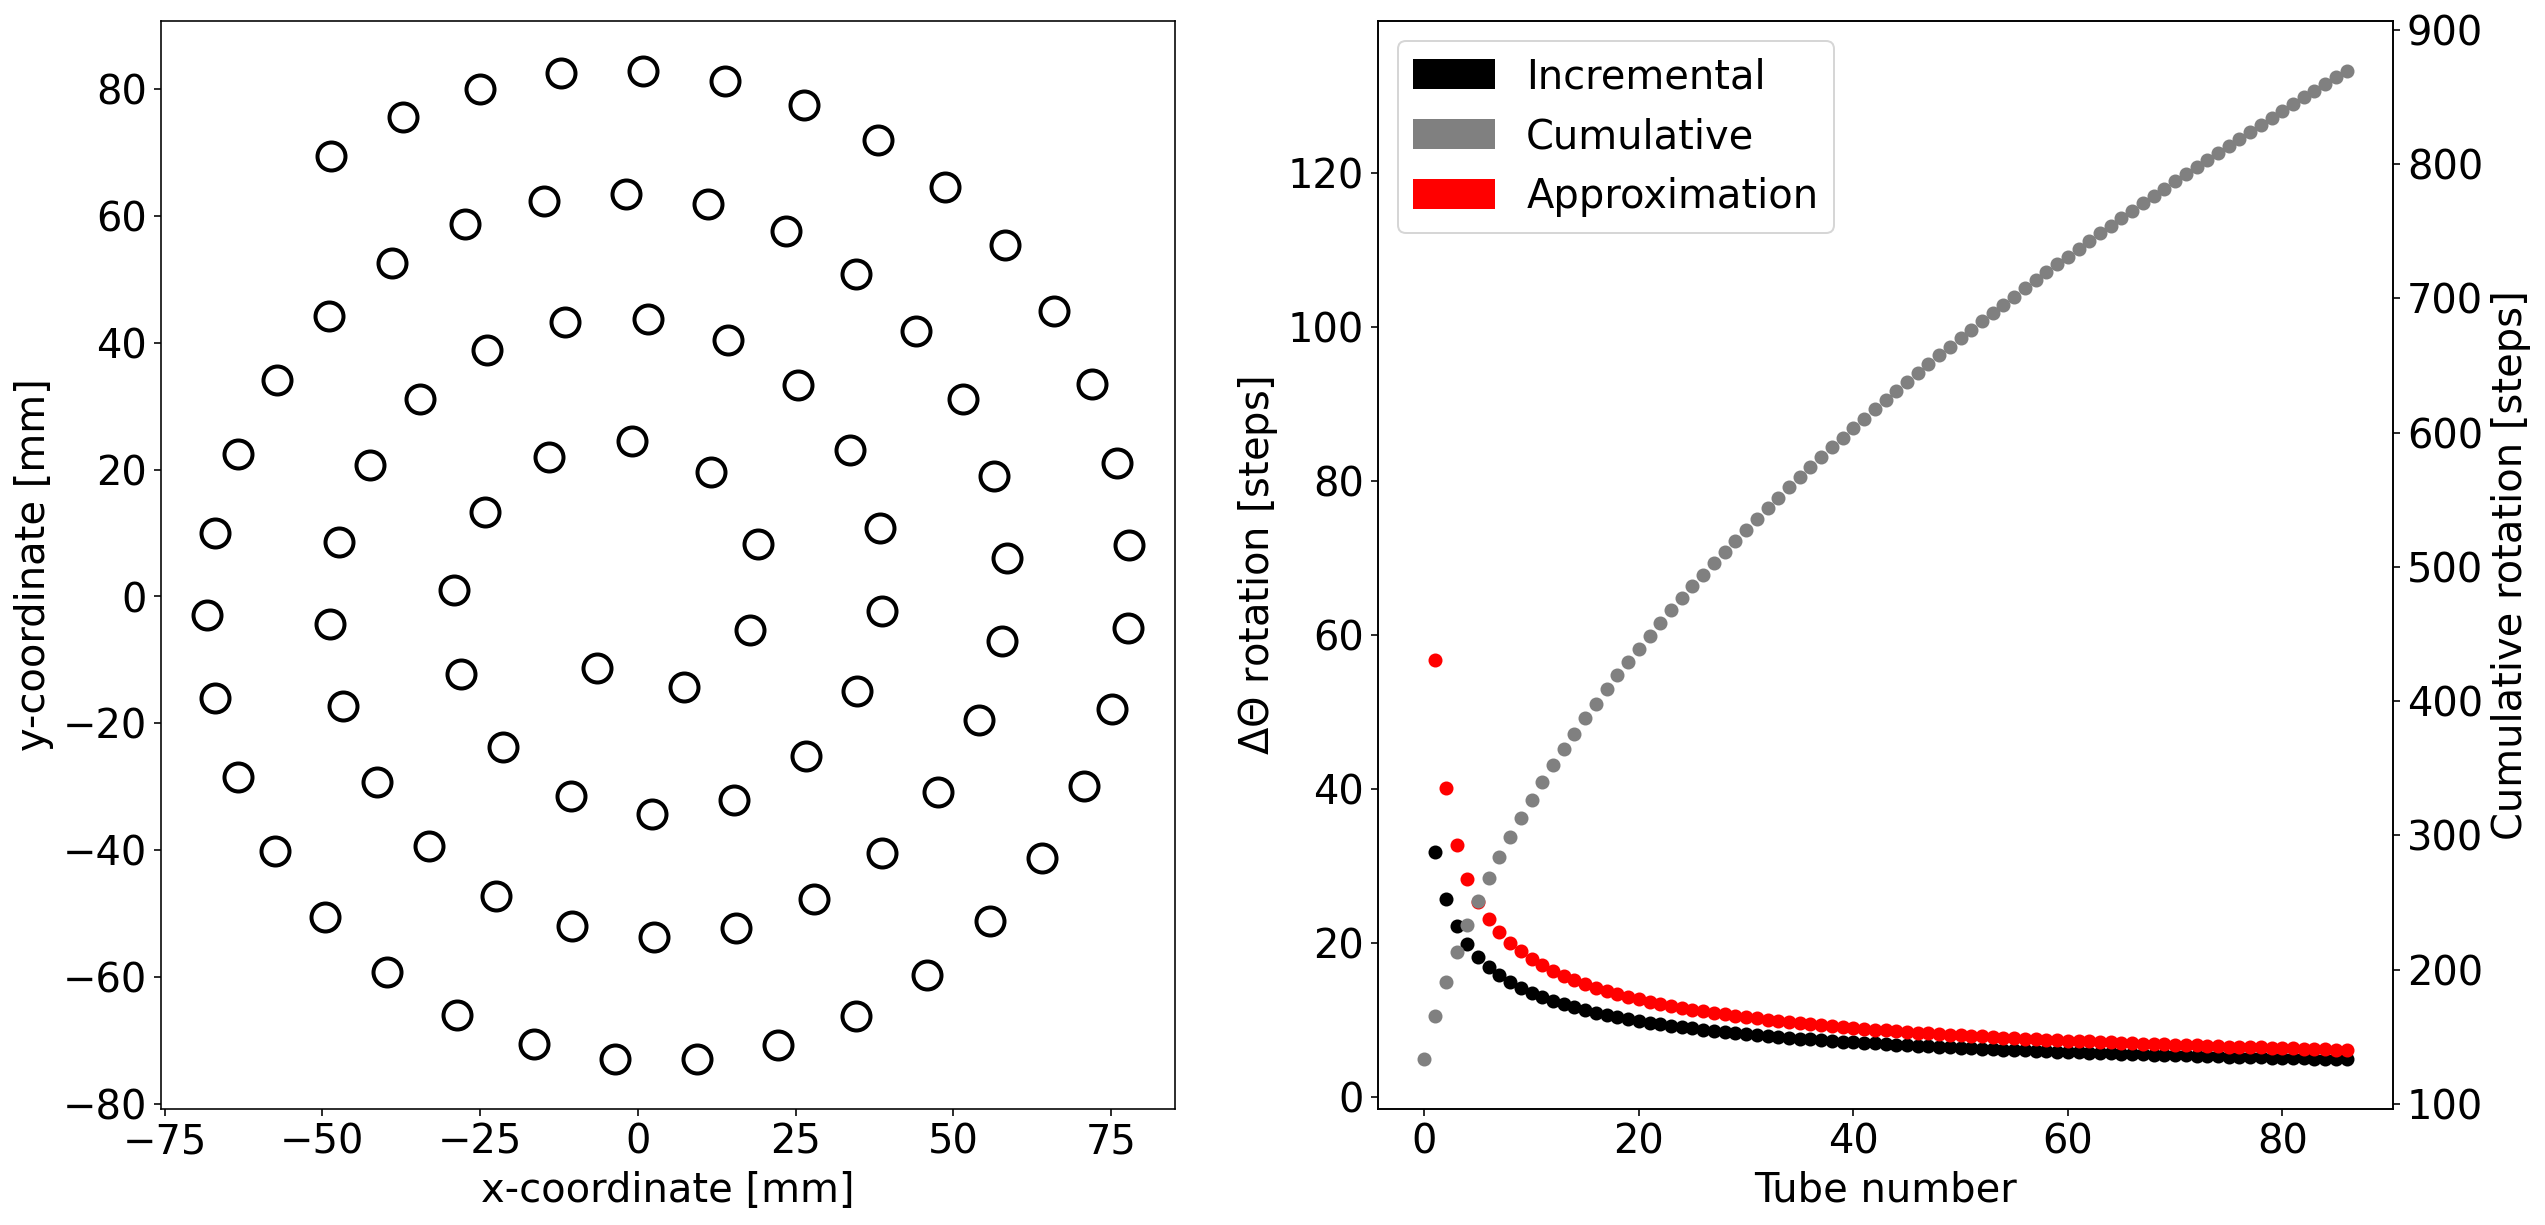

In [20]:
fig, ax = plt.subplots(figsize=(10*2, 10), ncols=2)

xx = data[:,0][1:]
yy = data[:,1][1:]

ax[0].plot(xx,yy, 'o', ms=14, markerfacecolor="None",markeredgecolor='black', markeredgewidth=2)
ax[0].set_xlabel("x-coordinate [mm]")
ax[0].set_ylabel("y-coordinate [mm]")

ax2 = ax[1].twinx()
xx = np.arange(len(theta)-1)
yy = theta[1:] - theta[:-1]

# to fix the the jump in theta due to branch cuts
# we add a contant back to those values that cross the
# branch. There is certainly a more elegant way to do this.

for idx, i in enumerate(yy):
    if i < -50:
        yy[idx] = yy[idx] + 200

ax[1].scatter(xx, yy, color="black")
ax2.scatter(xx, np.cumsum(yy), color="grey", zorder=-1)
ax2.set_ylabel("Cumulative rotation [steps]")
ax[1].scatter(xx, np.pi/np.sqrt(b*xx)*180*200/np.pi/360, color='r')

ax[1].set_xlabel("Tube number")
ax[1].set_ylabel("$\Delta \Theta$ rotation [steps]")

grey_patch = mpatches.Patch(color='grey', label='Cumulative')
black_patch = mpatches.Patch(color='black', label='Incremental')
red_patch = mpatches.Patch(color='red', label='Approximation')

plt.legend(handles=[black_patch, grey_patch, red_patch], loc="upper left")

# plt.savefig("../figures/analytical.pdf", bbox_inches='tight')
# plt.savefig("../figures/analytical.png", bbox_inches='tight', dpi=100)


fig.show()

# Scalability plot

In [21]:
fr = 10 # mL/hr
fractions = 88
per_volume = 1 # mL
num_fc = np.arange(1, 20)

hours = fractions*per_volume / num_fc/fr
cost_per = 70

In [22]:
fractions/fr/num_fc

array([8.8       , 4.4       , 2.93333333, 2.2       , 1.76      ,
       1.46666667, 1.25714286, 1.1       , 0.97777778, 0.88      ,
       0.8       , 0.73333333, 0.67692308, 0.62857143, 0.58666667,
       0.55      , 0.51764706, 0.48888889, 0.46315789])

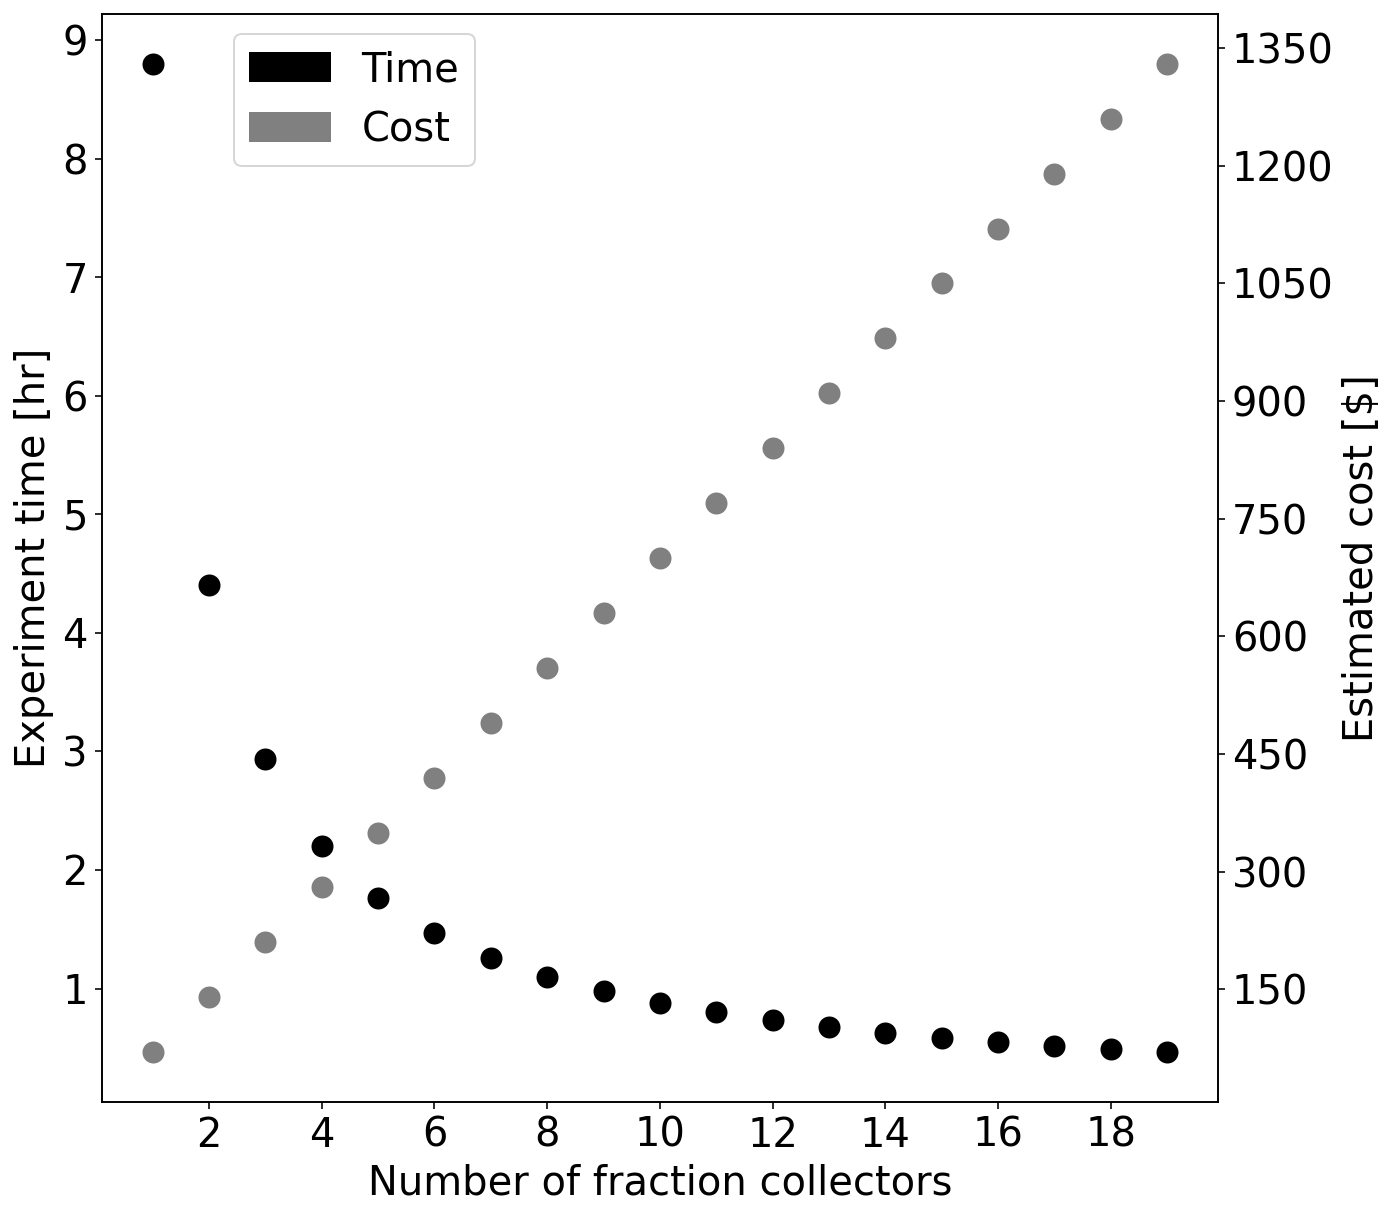

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax2 = ax.twinx()

ax.scatter(num_fc, hours, c='k', s=100, label="Time")

ax.set_xlabel("Number of fraction collectors")
ax.set_ylabel("Experiment time [hr]")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


ax2.scatter(num_fc, [i*cost_per for i in range(1, 20)], c='grey', s=100, label="Cost")

ax2.set_ylabel("Estimated cost [$]")
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

grey_patch = mpatches.Patch(color='grey', label='Cost')
black_patch = mpatches.Patch(color='black', label='Time')
plt.legend(handles=[black_patch, grey_patch], loc="upper left", bbox_to_anchor=(0.1, 1))

# plt.savefig("../figures/time_cost_scale.pdf", bbox_inches='tight')
# plt.savefig("../figures/time_cost_scale.png", bbox_inches='tight', dpi=100)


fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


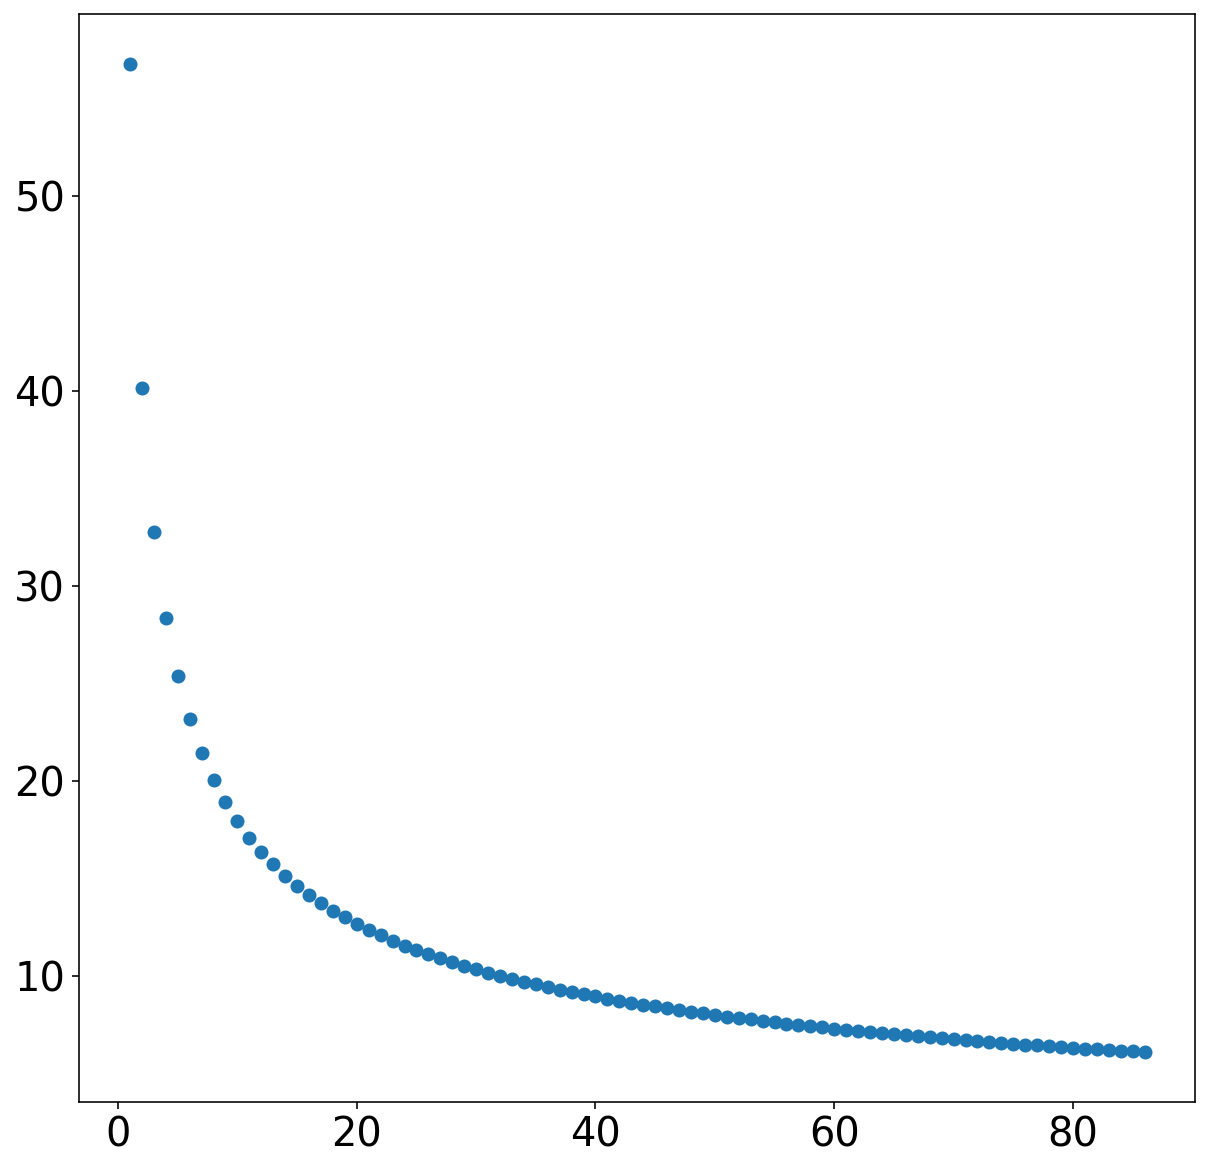

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(xx, np.pi/np.sqrt(b*xx)*180*200/np.pi/360)

plt.show()